In [27]:
import numpy as np
from pyspark.sql import SparkSession
import string
from collections import Counter
from PIL import Image
from operator import add
import json
import re
from scipy.sparse import coo_matrix
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row

spark = SparkSession.builder.master('local[28]').appName('zillow').getOrCreate()

In [28]:
train_file = '/project/cmsc25025/zillow/zillow-train.csv'
test_file = '/project/cmsc25025/zillow/zillow-test.csv'

In [4]:
#cannot read the file in DROPMALFORMED mode -- skip too many lines! lose over 90% of data
#from pyspark.sql import SQLContext
#sqlContext = SQLContext(spark)
#b = sqlContext.read.format("com.databricks.spark.csv").schema(schema).option("header", "true").option("mode", "PERMISSIVE").load(train_file)

In [29]:
#read data
raw_train = spark.read.csv(train_file,header=True)

In [5]:
#raw_train.rdd.take(1)

In [30]:
#convert categorical types to indices

from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString
strTypes = ['MSA','City','HighSchool']

myIndexer = dict()
myConverter = dict()
myIndexerModel = dict()
for s in strTypes:
    myIndexer[s] = StringIndexer(inputCol=s,outputCol=s+'_ix').setHandleInvalid("skip")
    myIndexerModel[s] = myIndexer[s].fit(raw_train)
    raw_train = myIndexerModel[s].transform(raw_train)
    myConverter[s] = IndexToString(inputCol=s+'_ix', outputCol=s)

In [31]:
raw_train.select('MSA','MSA_ix','City','City_ix','HighSchool','HighSchool_ix').show(3)

+-------+------+--------------+-------+--------------------+-------------+
|    MSA|MSA_ix|          City|City_ix|          HighSchool|HighSchool_ix|
+-------+------+--------------+-------+--------------------+-------------+
|Chicago|   3.0|    Barrington|  378.0|Barrington High S...|        245.0|
|Chicago|   3.0|Mount Prospect|  150.0|Wheeling High School|        305.0|
|Chicago|   3.0|Mount Prospect|  150.0|John Hersey High ...|        225.0|
+-------+------+--------------+-------+--------------------+-------------+
only showing top 3 rows



In [32]:
#convert values to floats, assigning -1 to NANs, NONEs, etc.
def floatOrNeg(x):
    for badval in [u'NONE','NONE', u'NA','NA', u'UNKNOWN', 'UNKNOWN']:
        if x == badval: #had issues when was using 'is' instead of '==' here! careful!
            return -1.0
    else:
        return float(x)

In [33]:
#clean up values in a Row of the data frame
#keep only numerical indices of MSA, City and HighSchool variables
def mapRow(x):
    numTypes = ['ID','Lat','Long','ListPrice','SaleYear','Bathroom','Bedroom',\
            'BuiltYear','BuildDecade','MajorRenov','FinishSqFt','LotSqFt','SalePrice']
    strTypes = ['MSA_ix','City_ix','HighSchool_ix']
    newrow = dict()
    for feat in numTypes:
        if x[feat] is None or x[feat] == '*':
            newrow[feat] = -1.0
        else:
            newrow[feat] = floatOrNeg(x[feat].encode("ascii", "ignore"))
    for feat in strTypes:
        #newrow[feat] = x[feat].encode("ascii", "ignore")
        newrow[feat] = x[feat] #converted to float via StringIndexer
    return Row(**newrow)

In [34]:
train_num = raw_train.rdd.map(lambda x: mapRow(x))
one_row = train_num.take(1)
# print one_row
train_num_cols = one_row[0].asDict().keys() #need column names for next part

## 3 (a) Data exploration

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

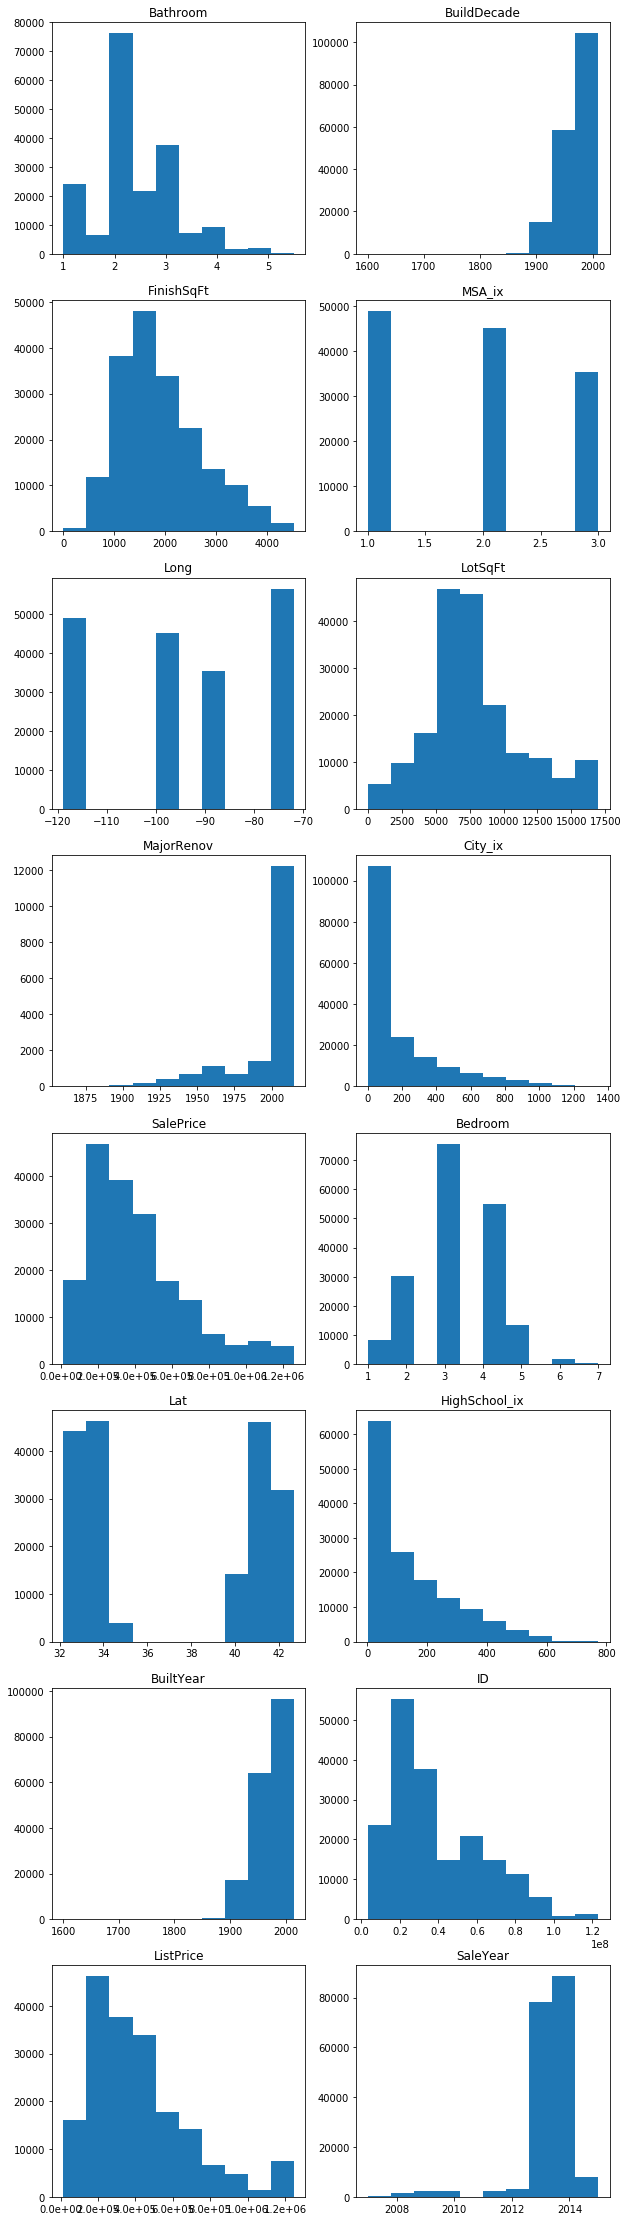

In [36]:
features = train_num_cols
plt.figure(figsize=(10,40))
for i in np.arange(len(features)):
    ax = plt.subplot(8, 2, i+1)
    thisfeat = train_num.map(lambda x: x[features[i]]).collect()
    thisfeat=np.array(thisfeat)
    if features[i] == 'Lat' or features[i] == 'Long':
        plt.hist(thisfeat,normed=0)
    else:
        plt.hist(thisfeat[thisfeat > 0],normed=0)
    plt.title(features[i])
    
    if features[i] == 'SalePrice' or features[i] == 'ListPrice':
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

The categorical variables here are HighSchool, City and MSA (metropolitan statistical area), which I have already converted to numerical values using StringIndexer above. There are only 4 MSA values, 1344 cities and 744 high schools listed in the database. (Note all of the NA, NONE, UNKNOWN values are excluded from these plots).

It looks like some values are raw, whereas others seem to have been preprocessed. For example, it seems strange that latitude and longtitude fall into such large bins with huge gaps in-between. Have there really been no homes sold at -80 longtitude? Also, it seems strange that there are so few (3) metropolitan areas in the dataset. Perhaps there weren't statistically significant numbers in other bins, so Zillow excluded them from the dataset? Regarding SalePrice, I'm surprised there aren't mroe expensive homes (e.g., multi-million dollar sales).

## 3 (b) Random forest models to predict SalePrice

In [37]:
from pyspark.mllib.regression import LabeledPoint

In [38]:
#map rows to LP
def map2LP(x):
    #get rid of posting ID, BuiltYear,
    feature_names = ['Lat','Long','ListPrice','SaleYear','Bathroom','Bedroom',\
                'BuildDecade','MajorRenov','FinishSqFt','LotSqFt',\
                'MSA_ix','City_ix','HighSchool_ix']
    label_name = 'SalePrice'
    label = x[label_name]
    #print label
    features = [x[ft] for ft in feature_names]
    #print features
    return LabeledPoint(label, features)

In [42]:
#convert all rows to LabeledPoints, must filter out data where we don't have a sale price
#otherwise, test error calculation is messed up
train_lp = train_num.filter(lambda x: x['SalePrice'] > 0).map(lambda x: map2LP(x))
#print train_num.take(1)
#print train_lp.take(1)

In [43]:
#compute no. unique values for all categorical variables
feature_names = ['Lat','Long','ListPrice','SaleYear','Bathroom','Bedroom',\
                'BuildDecade','MajorRenov','FinishSqFt','LotSqFt',\
                'MSA_ix','City_ix','HighSchool_ix']
catVars =['MSA_ix','City_ix','HighSchool_ix']
catVarDict = dict()
for c in catVars:
    catVarInd = feature_names.index(c)
    num_unique = train_num.map(lambda x: x[c]).distinct().count()
    catVarDict[catVarInd] = num_unique

In [44]:
print catVarDict

{10: 4, 11: 1344, 12: 774}


In [45]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

# Load and parse the data file into an RDD of LabeledPoint.
data = train_lp

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy=’’auto’’ lets the algorithm choose.
model = RandomForest.trainRegressor(trainingData,categoricalFeaturesInfo=catVarDict,\
            numTrees=12, featureSubsetStrategy='auto',\
            impurity='variance', maxDepth=18, maxBins=1400) #maxBins was 32

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))

In [46]:
labelsAndPredictions = \
            testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(\
        lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
testMeanPercentError = labelsAndPredictions.map(\
        lambda (v,p): np.abs(v-p)/float(v)).sum() / float(testData.count())

print('Test Mean Squared Error = ')
print "%2.2e" % (testMSE)
print('Test Sqrt Mean Squared Error = ')
print "%.0f dollars" % (np.sqrt(testMSE))
print('Test %Error = ')
print "%2.2f avg percent error" % (100*testMeanPercentError)
#print('Learned regression forest model:')
#print(model.toDebugString())

Test Mean Squared Error = 
2.76e+08
Test Sqrt Mean Squared Error = 
16623 dollars
Test %Error = 
3.03 avg percent error


In [47]:
model_for_c = model #will use this model in prediction below

I tried many sets of numTrees, maxDepth in the following ranges: numTrees=3-12,  maxDepth=3-15. I also ran this with and without explcitly defining categorical variables. I compared different models based on their %error on test data. 

A few examples below with saved output values: 
- numTrees=8 , maxDepth = 8,  including categorical data --> 5.15% error
- numTrees=12, maxDepth = 8,  including categorical data --> 4.96% error
- numTrees=8 , maxDepth = 12, including categorical data --> 3.23% error
- numTrees=12, maxDepth = 14, including categorical data --> 3.02% error
- numTrees=14, maxDepth = 14, including categorical data --> 3.05% error
- numTrees=12, maxDepth = 18, including categorical data --> 3.00% error

A few observations:

1. You get much better results with a larger depth and larger number of trees (numTrees=12, maxDepth = 14, including categorical data --> 3.02% error). It seems like depth matters more for accuracy (makes sense -- can predict more accurately with more decision points), but deeper trees take longer to compute. In general, larger values for both variables lead to more accurate predictions on test data, but up to a point. I wasn't able to get any prediction errors below 3%. I think this is generally in agreement with our expectations. Larger numbers of trees reduce variance and deeper trees reduce bias. 
2. Running these RF models for large numbers of trees and depths requires lots of computational resources. When I was running these jobs on Sandyb, I couldn't go past $\approx$8-10 numTrees and maxDepth. I couldn't get much better than 4-5% accuracy with those parameters. 
3. On Broadwl, using 24 cores, I can push both parameters >12, and it makes a difference. 
4. It looks like adding categorical variables explicitly does improve performance a bit, as promised in the documentation. However, including this option requires having at least as many bins as there are categories (1400 max in this case). When I attempted to include these categories explicitly on Sandyb, the jobs simply crashed.
5. It's more efficient to make these models if unimportant covariates are removed. For example, I removed 'BuildYear' (thinking it's already incorporated in 'BuildDecade') and 'ID' (I don't know why a listing ID would correlate with sales prices).
6. It seems like including 'ListPrice' in the covariates is cheating a bit... I haven't looked at this, but I suspect that 'SalePrice' strongly correlates with it. In fact, removing 'ListPrice' from the list of covariates sharply reduces regression quality (~10-15% error for numTrees, maxDepth in the range of 8-10, from what I remember).

In [51]:
#test goodness of prediction by plotting
l_and_p = labelsAndPredictions.collect()
l,p= zip(*l_and_p)
f=plt.figure()
plt.plot(l,p,'.')
plt.xlabel('true sale price')
plt.ylabel('predicted sale price')

## 3(c) Predicting sale prices

In [48]:
#read data
raw_test = spark.read.csv(test_file,header=True)

In [56]:
#raw_test.show()

In [49]:
print myIndexer

{'City': StringIndexer_4ff09a64326d99b9000d, 'HighSchool': StringIndexer_4569a7d73fa89fb87a15, 'MSA': StringIndexer_41deaaa844036301c3ee}


In [50]:
#must use stringIndexers trained on train_data above to index the test_data!
#it's important that the indexer up top has been set to handle invalid keys by throwing them out
#otherwise, results in errors
strTypes = ['MSA','City','HighSchool']
for s in strTypes:
    raw_test = myIndexerModel[s].transform(raw_test)

In [51]:
raw_test.select('SalePrice','MSA','MSA_ix','City','City_ix','HighSchool','HighSchool_ix').show(2)

+---------+-------+------+----------+-------+--------------------+-------------+
|SalePrice|    MSA|MSA_ix|      City|City_ix|          HighSchool|HighSchool_ix|
+---------+-------+------+----------+-------+--------------------+-------------+
|        *|Chicago|   3.0|  Oak Park|   92.0|Oak Park & River ...|         74.0|
|        *|Chicago|   3.0|Northfield|  598.0|New Trier Townshi...|         57.0|
+---------+-------+------+----------+-------+--------------------+-------------+
only showing top 2 rows



In [52]:
test_num = raw_test.rdd.map(lambda x: mapRow(x))
one_row = test_num.take(1)
# print one_row
test_num_cols = one_row[0].asDict().keys() #need column names for next part

In [44]:
#test_num.take(2)

In [53]:
#convert all rows to LabeledPoints, must hang on to ID for next part
#otherwise, test error calculation is messed up
#generate (ID,LabeledPoint tuples)
test_lp = test_num.map(lambda x: (int(x['ID']),map2LP(x))) #works: int(x['ID'])

In [36]:
#test_lp.take(1)

In [54]:
# Evaluate model on test instances
pred_part_c = model_for_c.predict(test_lp.map(lambda x: x[1].features))

In [55]:
pred_part_c.count()

20613

In [56]:
test_lp.count()

20613

In [57]:
#zip with ID
pred_and_ID = test_lp.map(lambda x: x[0]).zip(pred_part_c)

In [58]:
pred_and_ID_coll = pred_and_ID.collect()

In [59]:
#turn predictions into a dictionary {ID:predicted_price}
pred_and_ID_dict = dict(pred_and_ID_coll)

In [60]:
#test one dictionary entry
#pred_and_ID_dict[61960407]

166801.60057997558

In [67]:
#go through file, read line by line
#find the ID for a given line and append after the last comma the predicted price
in_file =  'my-zillow-test.csv'
out_file = 'my-zillow-predictions.csv'
cnt = 0
with open(in_file, 'r') as fin:
    with open(out_file,'w') as fout:
        for x in fin.readlines():
            #write header
            if cnt == 0:
                new_x = x
                fout.write(new_x)
                #fout.write('\n')
            if cnt > 0:
                this_id = int(str.split(x,',')[0])
                try:
                    this_pred = pred_and_ID_dict[this_id]
                    new_x = x[:-2]+str(this_pred) #trim last symbol (*) and replace by predicted price
                    fout.write(new_x)
                    fout.write('\n')
                except KeyError:
                    fout.write(x)
            cnt=cnt+1
fout.close()
fin.close()